In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
matplotlib.style.use('ggplot')
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

Парсинг сайта www.imdb.com

In [ ]:
def write_parse_data(data):
    with open('IMDB.csv','a') as f:
        writer = csv.writer(f)
        writer.writerow((
                         data['title'],
                         data['director'],
                         data['year'],
                         data['time'],
                         data['genre1'],
                         data['genre2'],
                         data['genre3'],
                         data['age_limit'], 
                         data['actor1'],
                         data['actor2'],
                         data['actor3'],
                         data['actor4'],
                         data['votes'],
                         data['IMDB']
                        
                         ))

In [ ]:
def get_text(film, tag, class_name):
    div = film.find(tag, class_= class_name)
    return div.getText("//")

In [ ]:
def encoding_letters(encod='utf-8'):
    
    letters=['á', 'å', 'ä', 'ã', 'â', 'à', 'æ', 'é', 'ë', 'ê', 'è',\
             'ì', 'í', 'î', 'ï', 'ò', 'ó', 'ô', 'õ', 'ö', 'ø', 'œ',\
             'ù', 'ú', 'û', 'ü', 'ß', 'ç', 'ҫ', 'ñ', 'ð',\
             'Á', 'Å', 'Ä', 'Ã', 'Â', 'À', 'Æ', 'É', 'Ë', 'Ê','È', \
             'Ì', 'Í', 'Î', 'Ï', 'Ò', 'Ó', 'Ô', 'Õ', 'Ö', 'Ø', 'Œ',\
             'Ù', 'Ú', 'Û', 'Ü', 'Ð', 'Ñ', 'Ç','Þ']
    codes=[]
    for i in letters:
        codes.append(i.encode(encod))
    return codes
  
def name(name,encod='utf-8'):
    d=encoding_letters()
    name=name.encode(encod)
    repl=['a', 'a', 'a', 'a', 'a', 'a', 'ae', 'e', 'e', 'e', 'e',\
          'i', 'i', 'i', 'i', 'o', 'o', 'o', 'o', 'o', 'o', 'oe',\
          'u', 'u', 'u', 'u', 'b', 'c', 'c', 'n', 'd',\
          'A', 'A', 'A', 'A', 'A', 'A', 'Ae', 'E', 'E', 'E', 'E',\
          'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'Oe',\
          'U', 'U', 'U', 'U', 'D', 'N', 'C', 'D']
   
    for i in range(len(d)):
        t=d[i]
        if name.find(t)!=-1:
            name=name.replace(t,repl[i].encode(encod))
    
    name=name.decode(encod)
       
    return name

In [ ]:
def get_page_data(html):
    soup = BeautifulSoup(html, 'lxml')
    divs = soup.find('div', class_='lister-list')
    films = divs.find_all('div', class_="lister-item-content")
    
    d=[]
    for film in films:
        try:
            try:
                div = film.find('h3',class_='lister-item-header').find('a').text
                title = name(div)
            except:
                title = ''

            try:
                div = film.find('span', class_="lister-item-year text-muted unbold").text
                year = div.replace('–','-')
            except:
                year = ''

            try:
                div = film.find('span', class_="runtime").text
                time = int(div.replace('min','')[:-1])
            except:
                time = 0

            try:
                div = film.find('span',class_="genre").text
                div=div.splitlines()[-1]
                genre1=''
                genre2=''
                genre3=''
                t=div.count(',')
                if t==0:
                    genre1=div.replace(' ','')
                if t==1:
                    genre1=div.split(',')[0].replace(' ','')
                    genre2=div.split(',')[1].replace(' ','')
                if t==2:
                    genre1=div.split(',')[0].replace(' ','')
                    genre2=div.split(',')[1].replace(' ','')
                    genre3=div.split(',')[2].replace(' ','')
            except:
                genre1=''

            try:
                div = film.find('div', class_='inline-block ratings-imdb-rating')
                rating = div.attrs['data-value']
            except:
                rating =''

            try:

                div = film.find('p', class_="sort-num_votes-visible").text.strip()
                votes = int(div.splitlines()[1].replace(',',''))
            except:
                votes=0

            try:
                div = film.find('span',class_='certificate').text
                age=div
            except:
                age=''
            
            try:
                div = film.findChildren('p')
                value=[]
                for cell in div:
                    value.append(cell.text)
                t=value[2]
                actor1, actor2, actor3, actor4=['' for i in range(4)]
                if t.find('Star')!=-1:
                    z=t.split(':')[-1].splitlines()
                    if len(z)==5:
                      actor1=name(z[1][:-2])
                      actor2=name(z[2][:-2])
                      actor3=name(z[3][:-2])
                      actor4=name(z[4])
                    elif len(z)==4:
                      actor1=name(z[1][:-2])
                      actor2=name(z[2][:-2])
                      actor3=name(z[3])
                      actor4=''
                    elif len(z)==3:
                      actor1=name(z[1][:-2])
                      actor2=name(z[2])
                      actor3=''
                      actor4=''
                    elif len(z)==2:
                      actor1=name(z[1])
                      actor2=''
                      actor3=''
                      actor4=''
                if t.find('Director')==-1:
                    director=''
                else:
                    y=t.split(':')[1].replace('Stars','').replace('|','')
                    director=''
                    for i in range(1,len(y.splitlines())):
                      director+=name(y.splitlines()[i])
                    director=director.splitlines()[0]
                
            except:
                director, actor1, actor2, actor3, actor4=['' for i in range(5)]

            data = {
                'title':title,
                'director':director,
                'year':year,
                'time':time,
                'genre1':genre1,
                'genre2':genre2,
                'genre3':genre3,
                'age_limit':age,
                'actor1':actor1,
                'actor2':actor2,
                'actor3':actor3,
                'actor4':actor4,
                'votes':votes,
                'IMDB':rating}
            
            
            write_parse_data(data)
        except UnicodeEncodeError:
            print(data)
            continue
     
   


In [ ]:
def main():
    base_url = 'https://www.imdb.com/'
    query_part = 'search/title/?genres=drama&'
    page_part = 'start='
    end_part='&explore=title_type,genres&ref_=adv_prv'
    for i in range(1,10001,50):
        url = base_url + query_part  + page_part + str(i)+end_part
        response = requests.get(url)
        html = response.text
        get_page_data(html)
        print(i, url)
        
        
main()

1 https://www.imdb.com/search/title/?genres=drama&start=1&explore=title_type,genres&ref_=adv_prv
51 https://www.imdb.com/search/title/?genres=drama&start=51&explore=title_type,genres&ref_=adv_prv
101 https://www.imdb.com/search/title/?genres=drama&start=101&explore=title_type,genres&ref_=adv_prv
151 https://www.imdb.com/search/title/?genres=drama&start=151&explore=title_type,genres&ref_=adv_prv
201 https://www.imdb.com/search/title/?genres=drama&start=201&explore=title_type,genres&ref_=adv_prv
251 https://www.imdb.com/search/title/?genres=drama&start=251&explore=title_type,genres&ref_=adv_prv
301 https://www.imdb.com/search/title/?genres=drama&start=301&explore=title_type,genres&ref_=adv_prv
351 https://www.imdb.com/search/title/?genres=drama&start=351&explore=title_type,genres&ref_=adv_prv
401 https://www.imdb.com/search/title/?genres=drama&start=401&explore=title_type,genres&ref_=adv_prv
451 https://www.imdb.com/search/title/?genres=drama&start=451&explore=title_type,genres&ref_=adv_

In [ ]:
from google.colab import files
files.download('IMDB.csv')  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df = pd.read_csv('IMDB.csv', encoding = 'utf-8', names=['title', 'director', 'year','time',\
                                                         'genre1','genre2','genre3','age_limit', 'actor1',\
                                                         'actor2', 'actor3','actor4','votes', 'IMDB'])
df.head(5)

,title,director,year,time,genre1,genre2,genre3,age_limit,actor1,actor2,actor3,actor4,votes,IMDB
0,Cobra Kai,NaN,(2018- ),30,Action,Comedy,Drama,TV-14,Ralph Macchio,William Zabka,Xolo Mariduena,Tanner Buchanan,96500,8.7
1,Bridgerton,NaN,(2020- ),60,Drama,Romance,NaN,TV-MA,Phoebe Dynevor,Rege-Jean Page,Nicola Coughlan,Jonathan Bailey,34264,7.4
2,Vikings,NaN,(2013-2020),44,Action,Adventure,Drama,TV-MA,Katheryn Winnick,Gustaf Skarsgard,Alexander Ludwig,Georgia Hirst,423980,8.5
3,The Queen's Gambit,NaN,(2020),393,Drama,Sport,NaN,TV-MA,Anya Taylor-Joy,Chloe Pirrie,Bill Camp,Marcin Dorocinski,217561,8.6
4,Chilling Adventures of Sabrina,NaN,(2018-2020),60,Drama,Fantasy,Horror,TV-14,Kiernan Shipka,Ross Lynch,Lucy Davis,Chance Perdomo,74390,7.5


In [ ]:

dt = pd.read_csv('IMDB.csv', encoding = 'utf-8', names=['title', 'director', 'year','time',\
                                                         'genre1','genre2','genre3','age_limit', 'actor1',\
                                                         'actor2', 'actor3','actor4','votes', 'IMDB'])
option='Alexander Ludwig'

dt[(dt.actor1==option)|(dt.actor2==option)|(dt.actor3==option)|(dt.actor4==option)]


,title,director,year,time,genre1,genre2,genre3,age_limit,actor1,actor2,actor3,actor4,votes,IMDB
2,Vikings,NaN,(2013-2020),44,Action,Adventure,Drama,TV-MA,Katheryn Winnick,Gustaf Skarsgard,Alexander Ludwig,Georgia Hirst,423980,8.5
4761,Heels,NaN,NaN,60,Drama,Sport,NaN,NaN,Stephen Amell,Kelli Berglund,Roxton Garcia,Alexander Ludwig,0,NaN
7275,When the Game Stands Tall,Thomas Carter,(2014),115,Drama,Sport,NaN,PG,Jim Caviezel,Alexander Ludwig,Michael Chiklis,Laura Dern,15362,6.7
8931,The Seeker: The Dark Is Rising,David L. Cunningham,(2007),99,Adventure,Drama,Family,PG,Alexander Ludwig,Ian McShane,Christopher Eccleston,Frances Conroy,14784,4.8


Описание, анализ и визуализация данных

In [ ]:
df.shape

(10000, 14)

In [ ]:
df.IMDB.isna().sum()

298

In [ ]:
df.genre3[df['genre3'].isna()]=' '
df.genre2[df['genre2'].isna()]=' '
df.loc[df.genre2.isin(['Drama']) , 'genre2'] = ' '
df.loc[df.genre3.isin(['Drama']) , 'genre3'] = ' '
for i in range(len(df)):
  if df.genre1[i]=='Drama' and (df.genre2[i]!=' ' or df.genre3[i]!=' '):
    df.genre1[i]=' '

In [ ]:
gen=list(set(df.genre1.tolist()+df.genre2.tolist()+df.genre3.tolist()))
gen.remove(' ')
val=df.genre1.tolist()+df.genre2.tolist()+df.genre3.tolist()
vals=[val.count(gen[i]) for i in range(len(gen))]
genres=pd.DataFrame({'c':vals},index=gen)
genres

,c
Reality-TV,9
Game-Show,4
Drama,1086
Mystery,1085
Adventure,928
Animation,332
Horror,510
Adult,1
Talk-Show,1
Musical,94


In [ ]:
g1=list(df['genre1'])
g2=list(df['genre2'])
g3=list(df['genre3'])
df['genre']=['']*len(df)

for i in range(len(df)):
      gs=[g1[i],g2[i],g3[i]]
      q3=[genres.c[gs[k]] if gs[k] in genres.index else 0 for k in range(3)]
      df['genre'][i]=gs[q3.index(max(q3))]

df.tail()

,title,director,year,time,genre1,genre2,genre3,age_limit,actor1,actor2,actor3,actor4,votes,IMDB,genre
9995,Someone Behind the Door,Nicolas Gessner,(1971),97,Crime,,,GP,Charles Bronson,Anthony Perkins,Jill Ireland,Henri Garcin,1204,6.0,Crime
9996,Operation Mincemeat,John Madden,NaN,0,,War,,PG-13,Colin Firth,Matthew Macfadyen,Kelly Macdonald,Penelope Wilton,0,NaN,War
9997,Foodie Love,NaN,(2019- ),0,Drama,,,NaN,Laia Costa,Guillermo Pfening,Thony Thornburg,Malcom McCarthy,1154,7.8,Drama
9998,By the Grace of God,Francois Ozon,(2018),137,Crime,,,NaN,Melvil Poupaud,Denis Menochet,Swann Arlaud,Eric Caravaca,5364,7.2,Crime
9999,Fahrenheit 9/11,Michael Moore,(2004),122,Documentary,,War,R,Michael Moore,George W. Bush,Ben Affleck,Stevie Wonder,126253,7.5,War


In [ ]:
df['year'].fillna(2021,inplace=True)
df['start_year']=df['year']
r=list(df['start_year'])
d=list(df['director'])
e=[0]*len(df)
typ=['']*len(df)
t=0

In [ ]:
for i in range(len(r)):
    y=str(r[i])
    y=y.replace('(','').replace(')','')
    if y.startswith("I") or y.startswith("V") or y.startswith("X"):
        t=y.find(' ')
        y=y[t+1:]
    if len(y)==4:
        r[i]=int(y)
        e[i]=int(y)
        if pd.isna(d[i]):
            typ[i]='Limited Series'
        else:
            typ[i]='Movie'
    elif len(y)==6:
        r[i]=int(y[:-2])
        e[i]=2021
        typ[i]='TV Series'
    elif len(y)==9:
        r[i]=int(y.split('-')[0])
        e[i]=int(y.split('-')[1])
        typ[i]='TV Series'
    elif len(y)>9:
        t=y.find(' ')
        r[i]=int(y[:t])
        e[i]=int(y[:t])
        typ[i]=y[t+1:]


In [ ]:
df['start_year']=r
df['end_year']=e
df['types']=typ


In [ ]:
#df.tail(15)

In [ ]:
df['actor1'].fillna('',inplace = True)
df['actor2'].fillna('',inplace = True)
df['actor3'].fillna('',inplace = True)
df['actor4'].fillna('',inplace = True)

In [ ]:
a1=list(df['actor1'])
a2=list(df['actor2'])
a3=list(df['actor3'])
a4=list(df['actor4'])
n=a1+a2+a3+a4
names=set()
names=set(n)
names.pop()
names=sorted(list(names))
print(len(names))
s1=df['actor1'].value_counts()
s2=df['actor2'].value_counts()
s3=df['actor3'].value_counts()
s4=df['actor4'].value_counts()

19196


In [ ]:
d={'a1':s1, 'a2':s2,'a3':s3, 'a4':s4}
data=pd.DataFrame(d)
data['a1'].fillna(0,inplace = True)
data['a2'].fillna(0,inplace = True)
data['a3'].fillna(0,inplace = True)
data['a4'].fillna(0,inplace = True)
data['a']=data.a1+data.a2+data.a3+data.a4


In [ ]:
data.drop([''], inplace=True)
data=data.drop(['a1','a2','a3','a4'],axis=1)



In [ ]:
data.head()


,a
50 Cent,5.0
A Martinez,2.0
A.J. Buckley,1.0
A.J. Cook,4.0
A.J. Saudin,1.0


Составим рейтинг актерского состава следующим образом: в таблице data посчитаны количество фильмов из выбранных данных, в которых снялся, актер - это будет его личный рейтинг. Рейтинг актерского состава - это сумма рейтингов 4 (или меньше) актеров.


In [ ]:
df['cast_rating']=[0]*len(df)
h=['']*len(df)
act1=list(df.actor1)
act2=list(df.actor2)
act3=list(df.actor3)
act4=list(df.actor4)
for i in range(len(df)):
  f=[act1[i], act2[i], act3[i], act4[i]]
  r=[data.a[f[k]] if f[k] in data.index else 0 for k in range(4)]
  f.clear
  r.clear
  df['cast_rating'][i]=sum(r)

In [ ]:
df=df.drop(['year'],axis=1)
df=df.drop(['genre1','genre2','genre3'],axis=1)
df=df.drop(['actor1','actor2','actor3','actor4'],axis=1)
df=df.drop(np.where(df['IMDB'].isna())[0])
df=df.drop(np.where(df['cast_rating']==0)[0])
df=df.drop('director',axis=True)
df.shape

(9697, 10)

In [ ]:
cols = df.columns.tolist()
cols=[cols[0]]+cols[6:8]+[cols[8]]+[cols[5]]+cols[1:3]+cols[9:]+cols[3:5]
df = df[cols]
df.head(10)

,title,start_year,end_year,types,genre,time,age_limit,cast_rating,votes,IMDB
0,Cobra Kai,2018,2021,TV Series,Comedy,30,TV-14,11,96500,8.7
1,Bridgerton,2020,2021,TV Series,Romance,60,TV-MA,8,34264,7.4
2,Vikings,2013,2020,TV Series,Action,44,TV-MA,18,423980,8.5
3,The Queen's Gambit,2020,2020,Limited Series,Sport,393,TV-MA,24,217561,8.6
4,Chilling Adventures of Sabrina,2018,2020,TV Series,Fantasy,60,TV-14,11,74390,7.5
5,The Crown,2016,2021,TV Series,Biography,58,TV-MA,46,142741,8.7
7,Pieces of a Woman,2020,2020,Movie,Drama,126,R,35,10448,7.1
8,Star Trek: Discovery,2017,2021,TV Series,Action,60,TV-14,7,93677,7.2
9,Game of Thrones,2011,2019,TV Series,Action,57,TV-MA,33,1753713,9.3
10,The Karate Kid,1984,1984,Movie,Action,126,PG,28,190438,7.3


In [ ]:
df[df.start_year.isna()]


,title,start_year,end_year,types,genre,time,age_limit,cast_rating,votes,IMDB


In [ ]:
df.age_limit.fillna('Not Rated', inplace=True)
df.loc[df.age_limit.isin(['TV-13', 'TV-14', 'PG-13']) , 'age_limit'] = 'PG-13'
df.loc[df.age_limit.isin(['Approved', 'Passed', 'Not Rated', 'Unrated']) , 'age_limit'] = 'Not Rated'
df.loc[df.age_limit.isin(['TV-Y7-FV', 'M', 'GP', 'TV-PG', 'PG']) , 'age_limit'] = 'PG'
df.loc[df.age_limit.isin(['TV-Y7', 'TV-Y', 'M/PG', 'TV-G', 'G']) , 'age_limit'] = 'G'
df.loc[df.age_limit.isin(['R', 'T', 'TV-MA']) , 'age_limit'] = 'R'
df.loc[df.age_limit.isin(['X', 'NC-17', 'MA-17']) , 'age_limit'] = 'NC-17'

In [ ]:
print(df['age_limit'].value_counts(), '\n')

R            3683
Not Rated    2625
PG-13        2007
PG           1047
G             300
NC-17          35
Name: age_limit, dtype: int64 



In [ ]:
print(df['types'].value_counts(), '\n')

Movie             6625
TV Series         2070
Limited Series     580
TV Movie           327
Video               55
Video Game          35
TV Short             3
TV Special           2
Name: types, dtype: int64 



In [ ]:
print(df['genre'].value_counts(), '\n')

Comedy         2242
Crime          1966
Romance        1201
Drama          1014
Action          803
Thriller        587
Biography       434
Mystery         339
Adventure       251
Fantasy         214
History         124
Horror           91
Family           91
War              81
Music            65
Sci-Fi           59
Sport            52
Western          40
Short             8
Film-Noir         8
Documentary       7
Animation         7
Reality-TV        6
Musical           6
Talk-Show         1
Name: genre, dtype: int64 



In [ ]:
df.IMDB=df.IMDB.apply(pd.to_numeric, errors='coerce')
df.votes=df.votes.apply(pd.to_numeric, errors='coerce')
df.time=df.time.apply(pd.to_numeric, errors='coerce')
df.start_year=df.start_year.apply(pd.to_numeric, errors='coerce')

df.dtypes

title           object
start_year       int64
end_year         int64
types           object
genre           object
time             int64
age_limit       object
cast_rating      int64
votes            int64
IMDB           float64
dtype: object

In [ ]:
new_df=df

In [ ]:
df.describe()

,start_year,end_year,time,cast_rating,votes,IMDB
count,9697.000000,9697.000000,9697.000000,9697.000000,9.697000e+03,9697.000000
mean,2004.352171,2005.338661,98.188203,24.951738,4.560356e+04,6.866959
std,17.715995,17.808970,55.110163,22.071071,1.179839e+05,1.019349
min,1915.000000,1915.000000,0.000000,0.000000,5.000000e+00,1.000000
25%,1997.000000,1998.000000,75.000000,8.000000,3.557000e+03,6.300000
50%,2011.000000,2012.000000,100.000000,17.000000,1.200900e+04,7.000000
75%,2017.000000,2018.000000,117.000000,36.000000,3.835100e+04,7.600000
max,2021.000000,2022.000000,931.000000,153.000000,2.332783e+06,9.700000


In [ ]:
categorical_columns= [column for column in df.columns if df[column].dtype == 'object'][1:]
numerical_columns = [column for column in df.columns if df[column].dtype != 'object']
numerical_columns

['start_year', 'end_year', 'time', 'cast_rating', 'votes', 'IMDB']

In [ ]:

colors = {
    'genre':'RdBu', 
    'types':'PiYG', 
    'time':'#7FFFD4', 
    'cast_rating':'#00BFFF',
    'age_limit':'RdPu',
    'IMDB':'#8B008B'
}


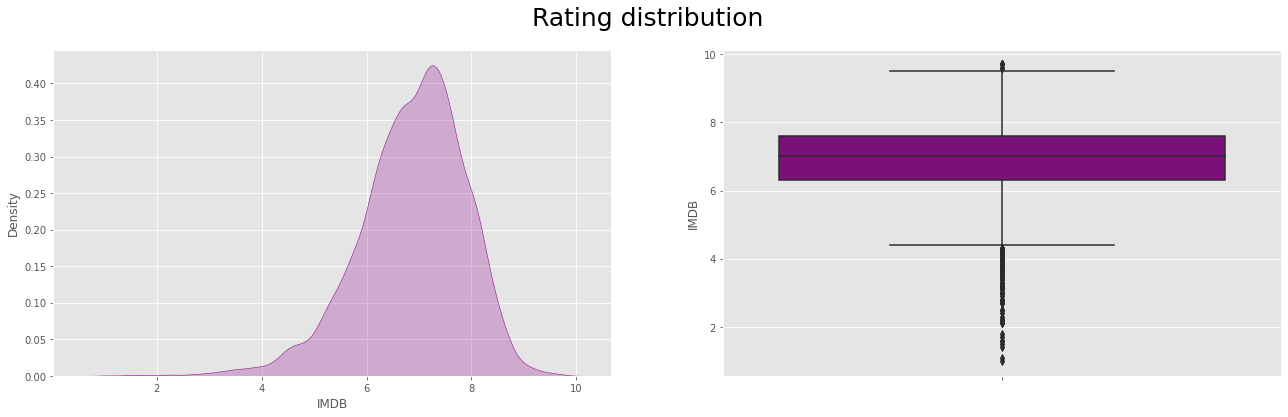

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,6))

plt.subplot(1,2,1)
ax = sns.kdeplot(df.IMDB, shade=True, color = colors['IMDB'])

plt.subplot(1,2,2)
ax = sns.boxplot(y=df.IMDB, color = colors['IMDB'])


fig.suptitle("Rating distribution",fontsize=25)
plt.show()

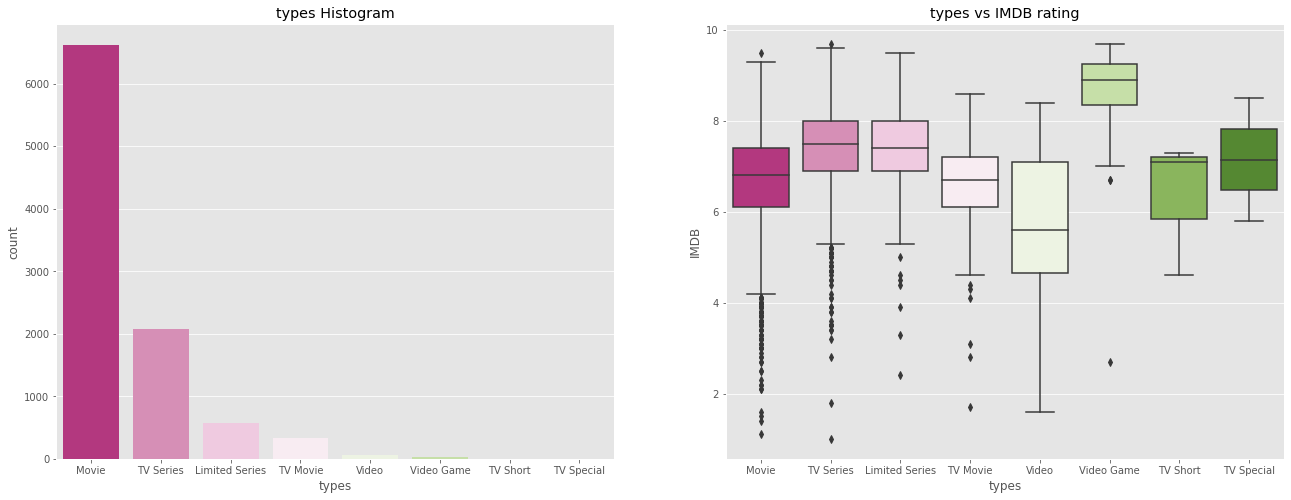

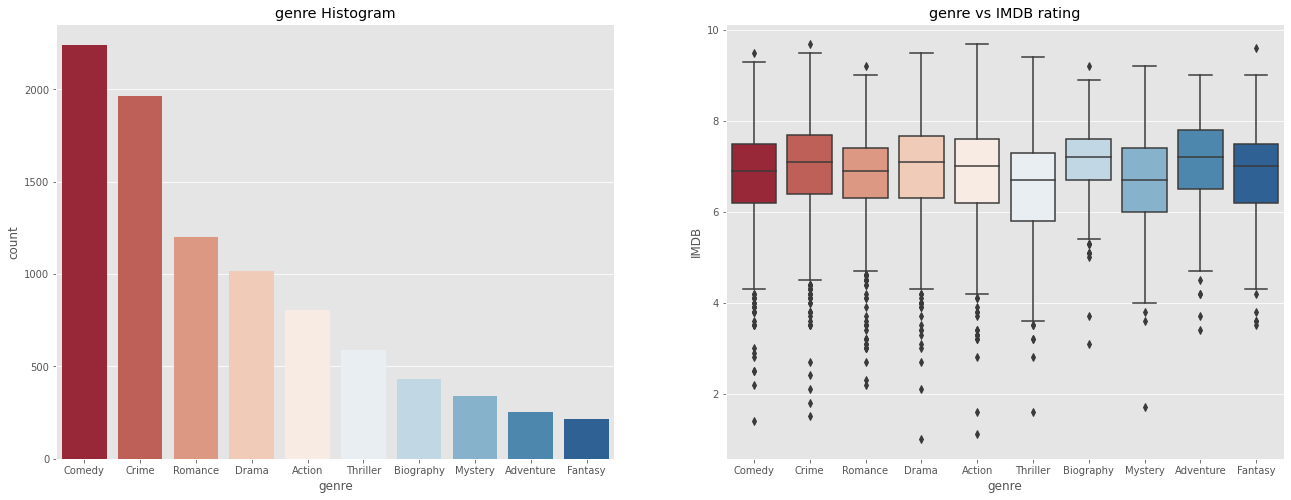

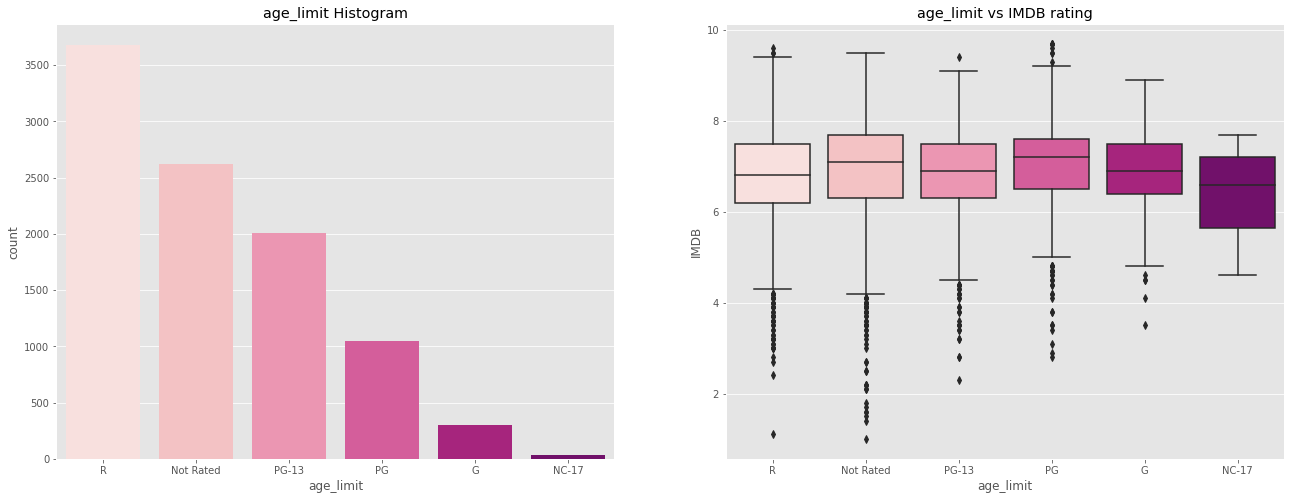

In [ ]:

for column in categorical_columns:
    
    columne_most_freq = df[column].value_counts()[:10].sort_values(ascending=False).index
    
    if '' in columne_most_freq:
        columne_most_freq = columne_most_freq.drop('')
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,8))    
    
    plt.subplot(1,2,1)
    plt.title(f'{column} Histogram')
    sns.countplot(
            df[df[column].isin(columne_most_freq)][column],
            order=columne_most_freq,
            palette=colors[column]
    )

    plt.subplot(1,2,2)
    plt.title(f'{column} vs IMDB rating')
    ax = sns.boxplot(
            x=df[df[column].isin(columne_most_freq)][column], 
            y=df['IMDB'], 
            order=columne_most_freq,
            palette=colors[column]
    )

    plt.show()

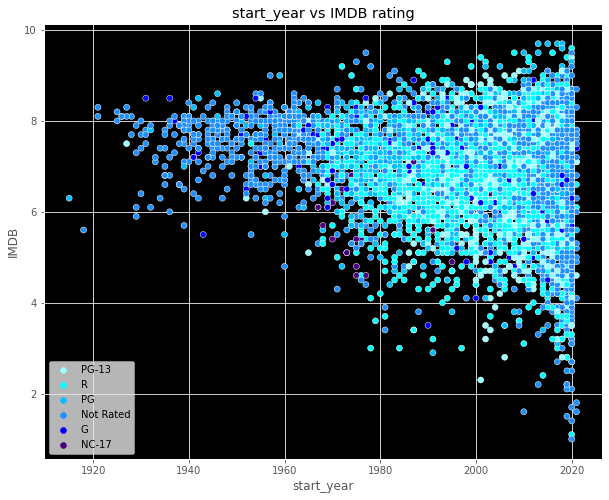

In [ ]:
cs=['#99ffff','#00FFFF', '#00BFFF', '#1E90FF', '#0000FF', '#4B0082']

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.scatterplot(x = 'start_year', y = 'IMDB', data=df, hue="age_limit", palette=cs)
ax.set(facecolor = "black")
ax.grid(axis = 'both', color='white')
plt.title('start_year vs IMDB rating')
plt.ylabel('IMDB')
plt.xlabel('start_year')
plt.legend()
plt.show()

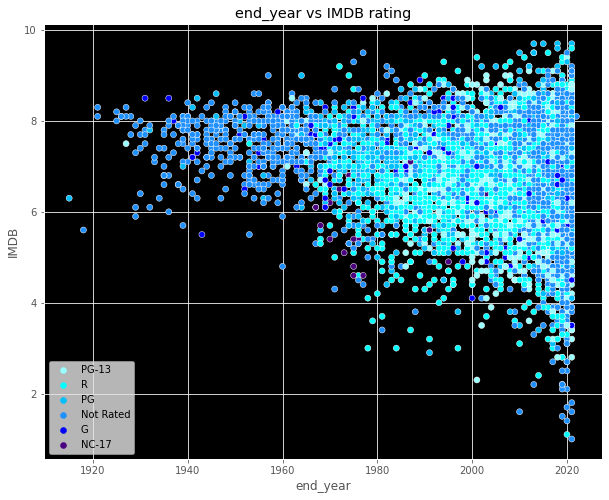

In [ ]:
cs=['#99ffff','#00FFFF', '#00BFFF', '#1E90FF', '#0000FF', '#4B0082']

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.scatterplot(x = 'end_year', y = 'IMDB', data=df, hue="age_limit", palette=cs)
ax.set(facecolor = "black")
ax.grid(axis = 'both', color='white')
plt.title('end_year vs IMDB rating')
plt.ylabel('IMDB')
plt.xlabel('end_year')
plt.legend()
plt.show()

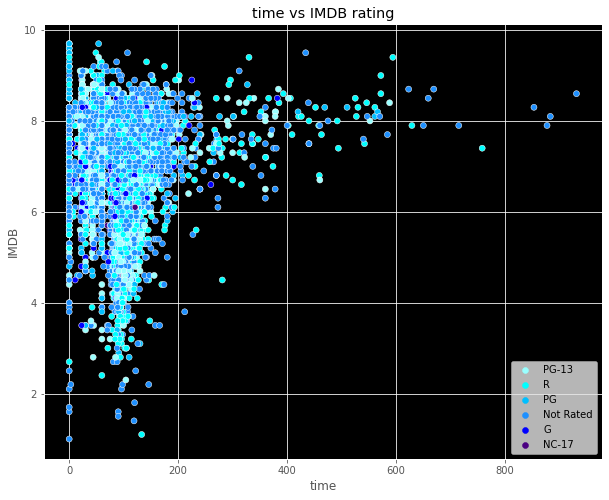

In [ ]:
cs=['#99ffff','#00FFFF', '#00BFFF', '#1E90FF', '#0000FF', '#4B0082']

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.scatterplot(x = 'time', y = 'IMDB', data=df, hue="age_limit", palette=cs)
ax.set(facecolor = "black")
ax.grid(axis = 'both', color='white')
plt.title('time vs IMDB rating')
plt.ylabel('IMDB')
plt.xlabel('time')
plt.legend()
plt.show()

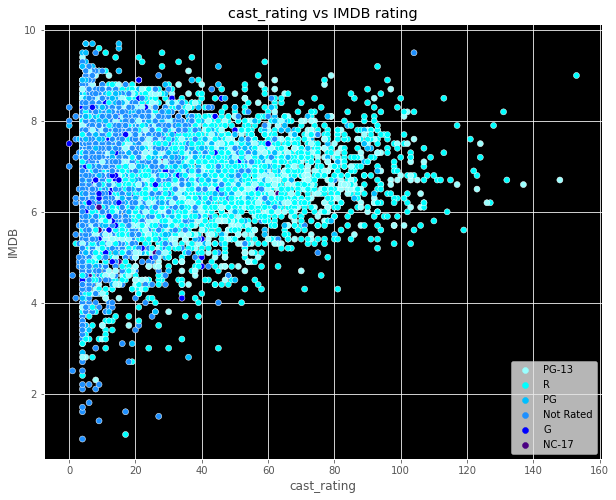

In [ ]:
cs=['#99ffff','#00FFFF', '#00BFFF', '#1E90FF', '#0000FF', '#4B0082']

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.scatterplot(x = 'cast_rating', y = 'IMDB', data=df, hue="age_limit", palette=cs)
ax.set(facecolor = "black")
ax.grid(axis = 'both', color='white')
plt.title('cast_rating vs IMDB rating')
plt.ylabel('IMDB')
plt.xlabel('cast_rating')
plt.legend()
plt.show()

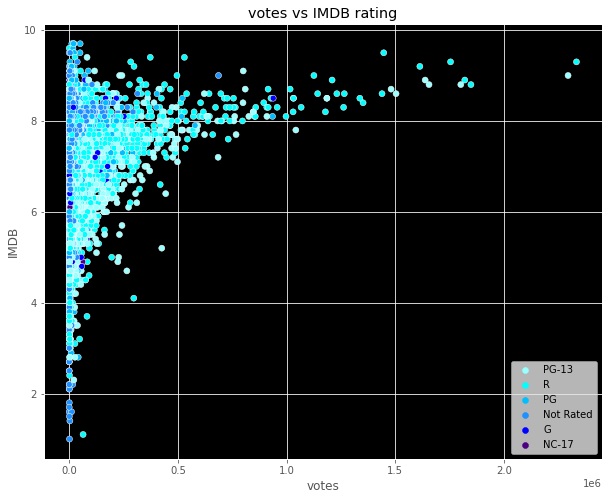

In [ ]:
cs=['#99ffff','#00FFFF', '#00BFFF', '#1E90FF', '#0000FF', '#4B0082']

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.scatterplot(x = 'votes', y = 'IMDB', data=df, hue="age_limit", palette=cs)
ax.set(facecolor = "black")
ax.grid(axis = 'both', color='white')
plt.title('votes vs IMDB rating')
plt.ylabel('IMDB')
plt.xlabel('votes')
plt.legend()
plt.show()

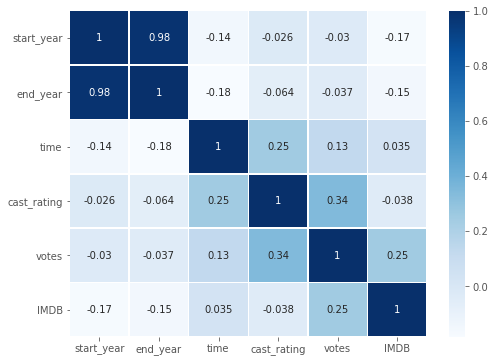

In [ ]:
plt.figure(figsize = (8, 6))
sns.heatmap(df.corr(), annot = True, linewidths=.5, cmap = 'Blues')
plt.show()

Обучение моделей


In [ ]:
import sklearn.preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from catboost import Pool, CatBoostRegressor,cv

In [ ]:
new_df.head()

,title,start_year,end_year,types,genre,time,age_limit,cast_rating,votes,IMDB
0,Cobra Kai,2018,2021,TV Series,Comedy,30,PG-13,11,96500,8.7
1,Bridgerton,2020,2021,TV Series,Romance,60,R,8,34264,7.4
2,Vikings,2013,2020,TV Series,Action,44,R,18,423980,8.5
3,The Queen's Gambit,2020,2020,Limited Series,Sport,393,R,24,217561,8.6
4,Chilling Adventures of Sabrina,2018,2020,TV Series,Fantasy,60,PG-13,11,74390,7.5


In [ ]:
X_new=new_df.drop(['title','IMDB'], axis=1)
y_new=new_df.IMDB

In [ ]:
X_tr, X_t, y_tr, y_t = train_test_split(X_new, y_new, test_size=0.2, random_state=17)
X_tr

,start_year,end_year,types,genre,time,age_limit,cast_rating,votes
428,2018,2021,TV Series,Comedy,43,PG-13,15,31101
2241,2012,2014,TV Series,Action,43,PG-13,17,80768
6364,2020,2020,TV Movie,Romance,87,PG,9,257
6000,2012,2012,TV Movie,Comedy,87,G,25,4199
3707,1990,1990,Movie,Crime,130,R,46,10491
...,...,...,...,...,...,...,...,...
8735,2017,2017,Movie,Crime,93,R,40,1502
6236,1997,1997,Movie,Romance,108,PG-13,35,5513
9827,1984,1984,Movie,Drama,110,Not Rated,8,982
419,2018,2021,TV Series,Comedy,43,PG-13,10,8238


In [ ]:
%%time
cat=CatBoostRegressor(cat_features=[2,3,5])
cat.fit(X_tr,y_tr,verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 12.3 s, sys: 1.63 s, total: 13.9 s
Wall time: 7.95 s


In [ ]:
preds = cat.predict(X_t)
print(preds)

[7.4039278  7.22745974 6.4089962  ... 7.85427162 5.89909717 6.74778114]


In [ ]:
r2 = r2_score(y_t, preds)
r2

0.49758907104232075

In [ ]:
%%time
cat=CatBoostRegressor(cat_features=[2,3,5])
params = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cat.grid_search(params, X=X_tr, y=y_tr, plot=True)
grid_search_result

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7076341838
bestIteration = 998

0:	loss: 0.7076342	best: 0.7076342 (0)	total: 4.18s	remaining: 2m 1s

bestTest = 0.7038916693
bestIteration = 585

1:	loss: 0.7038917	best: 0.7038917 (1)	total: 8.36s	remaining: 1m 57s

bestTest = 0.7090115254
bestIteration = 980

2:	loss: 0.7090115	best: 0.7038917 (1)	total: 12.4s	remaining: 1m 51s

bestTest = 0.7052822096
bestIteration = 694

3:	loss: 0.7052822	best: 0.7038917 (1)	total: 16.5s	remaining: 1m 47s

bestTest = 0.7109334779
bestIteration = 999

4:	loss: 0.7109335	best: 0.7038917 (1)	total: 20.5s	remaining: 1m 42s

bestTest = 0.7024956933
bestIteration = 828

5:	loss: 0.7024957	best: 0.7024957 (5)	total: 24.6s	remaining: 1m 38s

bestTest = 0.7113421293
bestIteration = 994

6:	loss: 0.7113421	best: 0.7024957 (5)	total: 28.6s	remaining: 1m 33s

bestTest = 0.7050671382
bestIteration = 984

7:	loss: 0.7050671	best: 0.7024957 (5)	total: 32.7s	remaining: 1m 30s

bestTest = 0.7136778889
bestIteration = 999

8:	loss: 0.7136779	best: 0.

In [ ]:
%%time
cat=CatBoostRegressor(depth=10, l2_leaf_reg=7, learning_rate=0.03, cat_features=[2,3,5])
cat.fit(X_tr,y_tr,verbose=False)
pred = cat.predict(X_t)
r2 = r2_score(y_t, pred)
r2

CPU times: user 46 s, sys: 2.57 s, total: 48.6 s
Wall time: 25.3 s


In [ ]:
r2

0.4918782109852756

In [ ]:

params = {'bagging_temperature':1,
   'random_strength':1,
   'thread_count':3,
   'iterations':100,
   'l2_leaf_reg' :4.0, 
   'learning_rate' : 0.07521709965938336,
   'random_seed':63,
   'od_type':'Iter',
   'od_wait':20,
   'custom_loss':'Accuracy',
   'eval_metric':'r2',
   'use_best_model':True,
   'cat_features': [2, 3, 5],
   'verbose':False}
pool1 = Pool(data=X_tr,
                  label=y_tr, cat_features=[2,3,5])

cat.fit(X_tr,
          y_tr,
          eval_set=pool1,
          verbose=False)

print(cat.get_best_iteration())

999


In [ ]:
cat.get_best_score()

{'learn': {'RMSE': 0.5931678053057923},
 'validation': {'RMSE': 0.6270139256359507}}

In [ ]:
pred = cat.predict(X_t)
r2 = r2_score(y_t, pred)
r2

0.4918782109852756

In [ ]:
features=cat.get_feature_importance()
features=features[:-1]

In [ ]:
predictors = ['start_year',
 'types',
 'genre',
 'time',
 'age_limit',
 'cast_rating',
 'votes']

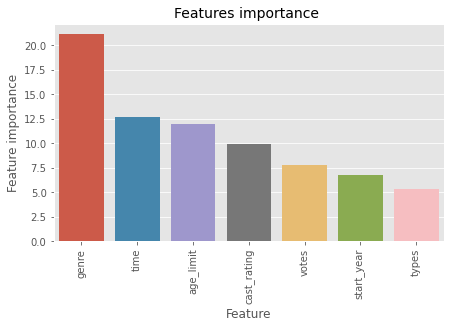

In [ ]:
s = pd.DataFrame({'Feature': predictors, 'Feature importance': features})
s = s.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance ',fontsize=14)
t=sns.barplot(x='Feature',y='Feature importance',data=s)
t.set_xticklabels(t.get_xticklabels(),rotation=90)
plt.show()   

In [ ]:

for feature in categorical_columns:
        label_encoder = sklearn.preprocessing.LabelEncoder()
        df[feature] = label_encoder.fit_transform(df[feature])





In [ ]:
df=df.drop(['title', 'end_year'],axis=1)
df.head()

,start_year,types,genre,time,age_limit,cast_rating,votes,IMDB
0,2018,3,4,30,4,11,96500,8.7
1,2020,3,17,60,5,8,34264,7.4
2,2013,3,0,44,5,18,423980,8.5
3,2020,0,20,393,5,24,217561,8.6
4,2018,3,9,60,4,11,74390,7.5


In [ ]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [ ]:
df.head()

,start_year,types,genre,time,age_limit,cast_rating,votes,IMDB
0,0.971698,0.428571,0.166667,0.032223,0.8,0.071895,0.041365,0.885057
1,0.990566,0.428571,0.708333,0.064447,1.0,0.052288,0.014686,0.735632
2,0.924528,0.428571,0.000000,0.047261,1.0,0.117647,0.181747,0.862069
3,0.990566,0.000000,0.833333,0.422127,1.0,0.156863,0.093260,0.873563
4,0.971698,0.428571,0.375000,0.064447,0.8,0.071895,0.031887,0.747126


In [ ]:
X=df.drop('IMDB', axis=1)
y=df.IMDB

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [ ]:
def fix_score(arr):
    arr = np.where(arr < 0, 0, arr)
    arr = np.where(arr > 10, 10, arr)
    return arr

In [ ]:
lin_reg = LinearRegression().fit(X_train, y_train)
tree = DecisionTreeRegressor().fit(X_train, y_train)
knn = KNeighborsRegressor().fit(X_train, y_train)
ridge = Ridge().fit(X_train, y_train)

x = []
for model in [lin_reg, tree, knn, ridge]:
    x.append({
        'model': model.__class__.__name__,
        'r2_test': r2_score(y_test, fix_score(model.predict(X_test)))
    })
pd.DataFrame(x)

,model,r2_test
0,LinearRegression,0.155028
1,DecisionTreeRegressor,-0.150918
2,KNeighborsRegressor,0.277228
3,Ridge,0.154234


In [ ]:
def find_best_model(model_class, X_train, X_test, y_train, y_test, params_grid, cv, name=None):
    model_grid = GridSearchCV(model_class, params_grid, cv=cv, n_jobs=-1, verbose=True)
    model_grid.fit(X_train, y_train)
    best_params = model_grid.best_params_ 
    r2 = r2_score(y_test, fix_score(model_grid.predict(X_test)))
    return (model_grid.best_estimator_, 
            pd.DataFrame([{"model": name or model_grid.best_estimator_.__class__.__name__, 'r2_train': model_grid.best_score_,
                          'r2_test':r2, **best_params}]))
    
    

In [ ]:
def test_all_models(X_train, X_test, y_train, y_test):
    tree_params = {'max_depth': range(1,50),
               'max_features': range(1,X_train.shape[1])}
    best_tree, stats_tree = find_best_model(DecisionTreeRegressor(), 
                                                        X_train, X_test, y_train, y_test, 
                                                        tree_params, cv=5)
    knn_params = {'knn__n_neighbors': range(1, 100)}
    knn_pipe = Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsRegressor(n_jobs=-1))])

    best_knn, stats_knn = find_best_model(knn_pipe, X_train, X_test, y_train, y_test,
                                                      knn_params, cv=5, name='KNN')
    
    ridge_params = {'alpha': [i/10 for i in range(1, 10)],
               'normalize': [True, False]}
    best_rigde, stats_rigde = find_best_model(Ridge(random_state=42), 
                                                        X_train, X_test, y_train, y_test, 
                                                        ridge_params, cv=5)
    
    comp = pd.concat([stats_tree, stats_knn, stats_rigde], axis=0, ignore_index=True)
    return comp[['model', 'r2_train', 'r2_test']]

In [ ]:
%%time
test_all_models(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1470 out of 1470 | elapsed:   24.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:   39.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits
CPU times: user 4 s, sys: 295 ms, total: 4.29 s
Wall time: 1min 5s


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished


,model,r2_train,r2_test
0,DecisionTreeRegressor,0.332419,0.302449
1,KNN,0.253550,0.318838
2,Ridge,0.158046,0.154960


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict

In [ ]:
%%time
forest= RandomForestRegressor().fit(X_train, y_train)
y_pred=forest.predict(X_test).reshape(-1,1)
training_score = cross_val_score(forest, X_train, y_train, cv=5)
print(training_score.mean() )
print(r2_score(y_test, y_pred))

0.4336164437247977
0.4426302689326225
CPU times: user 15.2 s, sys: 51 ms, total: 15.3 s
Wall time: 15.3 s


In [ ]:
%%time
boost= GradientBoostingRegressor().fit(X_train, y_train)
y_pred=boost.predict(X_test).reshape(-1,1)
training_score = cross_val_score(boost, X_train, y_train, cv=5)
print(training_score.mean() )
print(r2_score(y_test, y_pred))

0.4284177186873829
0.4497300314182098
CPU times: user 4.33 s, sys: 0 ns, total: 4.33 s
Wall time: 4.34 s


In [ ]:
%%time
forest_params={'n_estimators':list(range(50,150,10)),  
               'max_depth': range (1,13, 2)}
grid_forest = GridSearchCV(RandomForestRegressor(), forest_params,n_jobs=-1)
grid_forest.fit(X_train, y_train)
rand_forest = grid_forest.best_estimator_
rand_forest

CPU times: user 4.44 s, sys: 141 ms, total: 4.58 s
Wall time: 3min 18s


In [ ]:
%%time
#Gradient Boosting

boost_params={'n_estimators':list(range(50,200,10))}
grid_boost = GridSearchCV(GradientBoostingRegressor(), boost_params,n_jobs=-1)
grid_boost.fit(X_train, y_train)
grad_boost = grid_boost.best_estimator_
grad_boost

CPU times: user 2 s, sys: 42.5 ms, total: 2.04 s
Wall time: 45.9 s


In [ ]:
y_pred=rand_forest.predict(X_test).reshape(-1,1)
training_score = cross_val_score(boost, X_train, y_train, cv=5)
print(training_score.mean() )
print(r2_score(y_test, y_pred))

0.42853279793388976
0.46028624762094594


In [ ]:
y_pred=grad_boost.predict(X_test).reshape(-1,1)
training_score = cross_val_score(boost, X_train, y_train, cv=5)
print(training_score.mean() )
print(r2_score(y_test, y_pred))

0.42819675590192174
0.45949164158735767


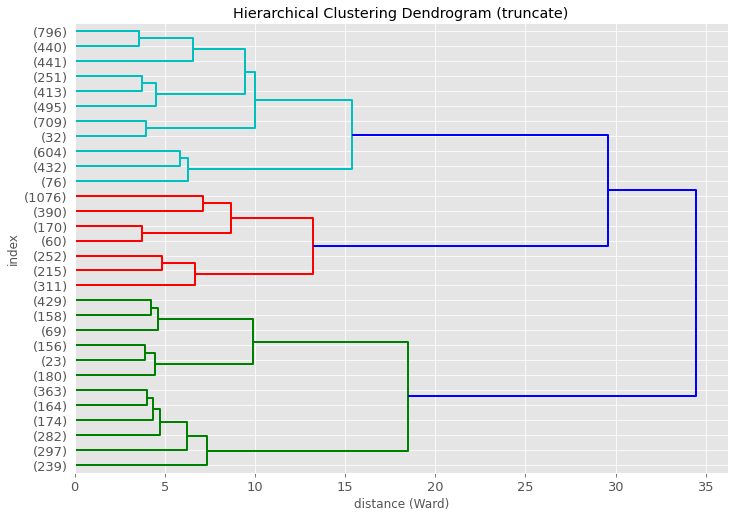

In [ ]:
link=link = linkage(X, 'ward', 'euclidean')
matplotlib.rcParams['lines.linewidth'] = 2

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

dn = dendrogram(link,
                labels=X.index.tolist(),
                truncate_mode='lastp',
                orientation = "right",
                )
ax.tick_params(labelsize=13)
plt.title('Hierarchical Clustering Dendrogram (truncate)')
plt.ylabel('index')
plt.xlabel('distance (Ward)')
plt.show()

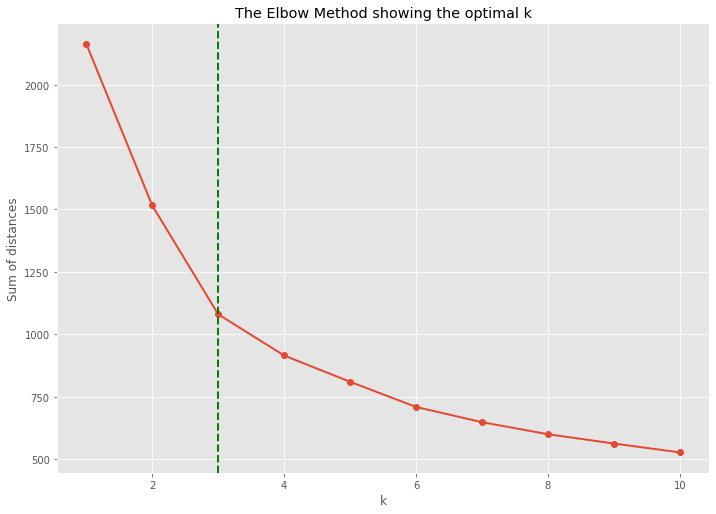

In [ ]:
K = range(1,11)
models = [KMeans(n_clusters=k, random_state=42).fit(X.iloc[:, :-1]) for k in K]
dist = [model.inertia_ for model in models]

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.axvline(3, c='g', linestyle='dashed')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(X)
X['cluster'] = model.labels_
X.groupby('cluster').mean()

,start_year,types,genre,time,age_limit,cast_rating,votes
cluster,,,,,,,
0,0.832557,0.185100,0.759495,0.113315,0.730750,0.168718,0.018597
1,0.807748,0.232597,0.211371,0.099979,0.412273,0.098276,0.007917
2,0.873547,0.202203,0.180423,0.104998,0.929497,0.205733,0.028285


In [ ]:
X.groupby('cluster').size()

cluster
0    2374
1    3031
2    4292
dtype: int64

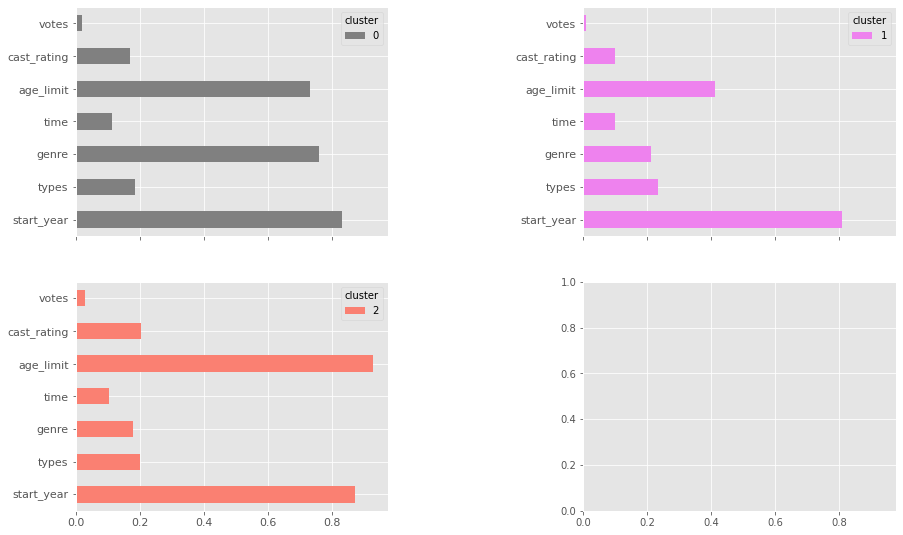

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
fig.set_size_inches(14.7, 9.27)
plt.subplots_adjust( wspace=0.625)
k = 0
c = ['grey', 'violet', 'salmon', 'skyblue', 'orange']
for i in range(2):
    for j in range(2):
      try:
        ax = axs[i, j]
        k += 1
        X[X.cluster == k-1].groupby('cluster').mean().T.plot.barh(ax = ax, color = c[k-1])
        ax.tick_params(labelsize = 11)
      except TypeError:
        continue
